In [8]:
import pysis.flowsheet as sim_f
from scipy import optimize
import pandas as pd
import sklearn
import scipy
import sklearn.ensemble as forest
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as metrics
import sklearn.gaussian_process as kriging
import seaborn as sns
from tensorflow import keras
from sklearn import preprocessing
from sklearn.pipeline import Pipeline, TransformerMixin, FeatureUnion
from sklearn.preprocessing import *
from feature_engine import wrappers,outliers

# from feature_engine import
from sklearn.compose import ColumnTransformer
from sklearn import model_selection
from sklearn.gaussian_process import GaussianProcessRegressor
from feature_engine.creation import MathFeatures, RelativeFeatures
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFECV
import optuna
import json
import pickle
import pyswarm
import pygad
import seaborn as sns 

In [9]:
from tensorflow import keras
from scikeras.wrappers import KerasRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.gaussian_process.kernels import RBF
from lightgbm import LGBMRegressor

In [10]:
class ColumnExtractor(TransformerMixin):
    def __init__(self,cols:str):
        self.cols=cols

    def transform(self,X:pd.DataFrame,y=None):
        self.Xcol=X.columns
        return self.Xcol 

    def fit(self,X,y=None):
        self.x=X
        return self
class PandasConversor(TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y=None):
        self.x=X
        return self
    def transform(self,X:pd.DataFrame,y=None):
        self.xpandas=pd.DataFrame(X)


In [11]:
def rna_model(
    features_in=87,
    hidden_layer_units=32,
    optimizer=keras.optimizers.Adam,
    optimizer__learning_rate=0.001,
    dropout=0.4,
):
    rna_model = keras.models.Sequential()
    rna_model.add(keras.layers.Input(shape=(features_in,)))
    rna_model.add(keras.layers.Dense(units=(features_in + 12), activation="relu"))
    rna_model.add(keras.layers.Dense(units=hidden_layer_units))

    rna_model.add(keras.layers.Dropout(rate=dropout))

    rna_model.add(keras.layers.LeakyReLU())
    rna_model.add(keras.layers.Dense(units=hidden_layer_units))

    rna_model.add(keras.layers.LeakyReLU())

    rna_model.add(keras.layers.Dropout(rate=dropout))
    rna_model.add(keras.layers.Dense(units=1, activation="linear"))

    rna_model.compile(
        loss="mean_squared_error",
        optimizer=optimizer(learning_rate=optimizer__learning_rate),
    )

    return rna_model

In [12]:
class SimulacaoCalc:
    def __init__(self, fs: sim_f.Simulation):
        self.fs = fs
        self.Operations = fs.Operations
        self.materialStreams = fs.MatStreams
        self.distillationColumn = sim_f.DistillationColumn(
            fs.Operations["T-100"].COMObject
        )
        self.Pfr = sim_f.PFR(self.fs.Operations["PFR-100"].COMObject)
        # fs.Solver.CanSolve=True
        self.fs.set_visible(1)
        pass

    def set_visible(self):
        self.fs.set_visible(1)

    def DesignVariables(self):
        return {
            "VolumeReator": self.Pfr.get_volume(),
            "AreaTC": [
                self.fs.Operations[u].COMObject.UAValue * 1000 / 1700
                for u in self.Operations.keys()
                if self.fs.Operations[u].classification == "Heat Transfer Equipment"
                and any(
                    [
                        x == "HeatTransferArea"
                        for x in self.fs.Operations[u].COMObject.__dir__()
                    ]
                )
            ],
            "VazaoWasteWater": self.fs.MatStreams[
                "LIQ"
            ].COMObject.IdealLiquidVolumeFlowValue
            * 1000,
            "PotenciaFornalha": self.fs.EnerStreams["Q-105"].get_power() / 1e3,
            "VolumePackingTD": self.fs.Operations["CustoDestilação"]
            .COMObject.Cell("A1")
            .CellValue,
            "PotenciaCompressores": [
                self.fs.Operations[u].COMObject.EnergyValue
                for u in self.Operations.keys()
                if self.Operations[u].classification == "Rotating Equipment"
            ],
            "MassaProcessVessel": [
                self.fs.Operations["ProcessVessel"].COMObject.Cell("B7").CellValue,
                self.fs.Operations["ProcessVessel"].COMObject.Cell("B8").CellValue,
            ],
        }

    def listDesignVariables(self):
        return np.array(list(self.DesignVariables().values())).flatten()

    def UCEquipamentos(self):
        design_variables = self.DesignVariables()

        return {
            "CustoReator": 4.00
            * (61500 + 32500 * (design_variables["VolumeReator"]) ** 0.80),
            "CustoTrocadoresDeCalor": sum(
                [1.0 * (28000 + 54 * u**1.20) for u in design_variables["AreaTC"]]
            ),
            "CustoTorreResfriamento": 2.5
            * (170000 + 1500 * design_variables["VazaoWasteWater"] ** 0.90),
            "CustoFornalha": 2.5
            * (80000 + 10900 * (design_variables["PotenciaFornalha"]) ** 0.80),
            "CustoDestilação": 4000 * design_variables["VolumePackingTD"],
            "CustoComp": sum(
                [
                    2.5 * (580000 + 20000 * (u) ** 0.6)
                    for u in design_variables["PotenciaCompressores"]
                ]
            ),
            "CustoProcessVessel": sum(
                [
                    4.0 * (17400 + 79 * (u) ** 0.85)
                    for u in design_variables["MassaProcessVessel"]
                ]
            ),
        }

    def CustoEquipamentos(self):
        return sum(list(self.UCEquipamentos().values()))

    def QntdUtilidades(self):
        return {
            "VazaoUtilidadeFria": self.fs.MatStreams[
                "UtilidadeFria"
            ].COMObject.IdealLiquidVolumeFlowValue
            * 3600,
            "PotenciaAquecimento": self.fs.Operations["UtilidadeQuenteCusto"]
            .COMObject.Cell("B4")
            .CellValue
            / 1e6
            * 3600,
            "VazaoWasteWater": self.fs.MatStreams[
                "LIQ"
            ].COMObject.IdealLiquidVolumeFLowValue
            * 3600,
            "PotenciaEletricidade": self.fs.EnerStreams["CustoEletricidade"].get_power()
            / 1e3,
        }

    def CustoUtilidades(self):
        qntdutilidades = self.QntdUtilidades()
        return {
            "CustoResfriamento": qntdutilidades["VazaoUtilidadeFria"] * 0.03,
            "CustoAquecimento": qntdutilidades["PotenciaAquecimento"] * 12.1,
            "CustoWasteWater": qntdutilidades["VazaoWasteWater"] * 1.5,
            "CustoEletricidade": qntdutilidades["PotenciaEletricidade"] * 94.5,
        }

    def CustoTotalUtilidades(self):
        return sum(list(self.CustoUtilidades().values()))

    def VazaoMP(self):
        return {
            "QntdH2": self.fs.MatStreams["9"].COMObject.IdealLiquidVolumeFlowValue
            * 3600,
            # ton
            "QntdCO2": self.fs.MatStreams["1"].get_massflow() / 1000,
        }

    def CustoMP(self):
        return {
            "CustoH2": self.VazaoMP()["QntdH2"] * 0.165,
            "CustoCO2": self.VazaoMP()["QntdCO2"] * 95.50,
        }

    def CustoTotalMP(self):
        return sum(list(self.CustoMP().values()))

    def simulated_values(self):
        return list(np.array(list(self.QntdUtilidades().values())).flatten()) + list(
            np.array(list(self.VazaoMP().values())).flatten()
        )

    def obj_f(self):
        return [
            self.CustoEquipamentos(),
            self.CustoTotalMP(),
            self.CustoTotalUtilidades(),
            self.fs.MatStreams["DestL"].get_compmassflow()["Methanol"],
        ]

    def set_dof(self, x):
        self.fs.Solver.CanSolve = False

        self.materialStreams["13"].set_temperature(x[0], "C")

        self.materialStreams["9"].set_molarflow(x[1], "kgmole/h")

        self.fs.Operations["TEE-100"].SplitsValue = (x[2], 1 - x[2])

        self.distillationColumn.set_specifications(spec="Reflux Ratio", value=x[3])

        self.Pfr.set_volume(x[4])

        self.materialStreams["10"].set_pressure(x[5], "kpa")
        self.materialStreams["8"].set_pressure(x[5], "kpa")
        self.materialStreams["20"].set_pressure(x[5], "kpa")

        self.materialStreams["REC-2"].set_pressure(x[5], "kpa")
        self.fs.Solver.CanSolve = True

    def RReciclo(self):
        self.materialStreams["REC"].set_molarflow(5.204e4)
        self.materialStreams["REC"].set_compmolarflow(
            self.materialStreams["REC-2"].get_compmolarflow()
        )
        streams_pressure = dict(
            zip(
                list(self.fs.MatStreams.keys()),
                [
                    self.fs.MatStreams[u].get_pressure()
                    for u in list(self.fs.MatStreams.keys())
                ],
            )
        )

    def profit(self):
        opex = (self.CustoTotalUtilidades() + self.CustoTotalMP())*24*30*12
        capex = (
            (
                self.CustoEquipamentos()
                + self.CustoEquipamentos() * 0.35
                + (self.CustoEquipamentos() + self.CustoEquipamentos() * 0.35) * 0.20
                + (self.CustoEquipamentos() + self.CustoEquipamentos() * 0.35) * 0.30
                + (self.CustoEquipamentos() + self.CustoEquipamentos() * 0.35) * 0.15
            )
            
        )

        tac=(capex*0.20+opex)/12/30/24
        methanol_sell = (
            self.fs.MatStreams["DestL"].get_compmassflow()["Methanol"] * 575 / 1000
        )
        return (methanol_sell - tac)

    def reset_stream(self):
        unconverged_streams = [
            i
            for i in list(self.fs.MatStreams.keys())
            if self.fs.MatStreams[i].COMObject.MassFlow() < 0
            or self.fs.MatStreams[i].COMObject.MolarEntropy() < 0
        ]
        streams_pressure = dict(
            zip(
                list(self.fs.MatStreams.keys()),
                [
                    self.fs.MatStreams[u].get_pressure()
                    for u in list(self.fs.MatStreams.keys())
                ],
            )
        )
        unconverged_streams_bool = any(
            [
                self.fs.MatStreams[i].COMObject.MassFlow() < 0
                or self.fs.MatStreams[i].COMObject.MolarEntropy() < 0
                for i in list(self.fs.MatStreams.keys())
            ]
        )
        for i in unconverged_streams:
            if self.fs.MatStreams[i].COMObject.CanModifyStream == True:
                self.fs.MatStreams[i].set_pressure(100)
                self.fs.MatStreams[i].set_pressure(streams_pressure[i])

    def reset_simulation(self):
        self.fs.close()
        self.fs = 0
        self.fs = sim_f.Simulation(
            path=(
                r"C:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\DWSIMSIMS\HidrogenaçãoCO2A.hsc"
            )
        )
        self.fs.set_visible(1)
        pass

In [13]:
dfx = pd.DataFrame(
    pd.read_csv(
        filepath_or_buffer="DadosMetamodelagemX4.csv",
        delimiter=",",
        index_col=False,
        names=[
            "ReactionTemperature",
            "H2FlowRate",
            "SplitsValues",
            "RefluxRatio",
            "ReactorVolume",
            "FeedPressure",
            "NANx",
        ],
    )
)
dfy = pd.DataFrame(
    pd.read_csv(
        "DadosMetamodelagemY4.csv",
        delimiter=",",
        names=[
            "ISBL",
            "CustoMateriaPrima",
            "CustoUtilidades",
            "Methanol",
            "IsValid",
            "IsConverged",
            "StreamConvergeance",
            "NANy",
        ],
    )
)
dfy["Methanol"] = dfy["Methanol"] * 32 * 575 / 1000


dft = pd.DataFrame.join(dfx, dfy)
dft.drop(dft.loc[dft["StreamConvergeance"] == False].index, inplace=True)
dft.drop(
    columns=["NANx", "NANy", "IsValid", "StreamConvergeance", "IsConverged"],
    inplace=True,
)
dft.reset_index(inplace=True, drop=True)
dft.astype(dtype=float, copy=True)
dft["ISBL"] = dft["ISBL"].astype(float)

df_isbl = dft["ISBL"]
df_osbl = df_isbl * 0.35
df_opex = dft["CustoMateriaPrima"] + dft["CustoUtilidades"]
df_capex = (
    (
        df_isbl
        + df_osbl
        + 0.20 * (df_osbl + df_isbl)
        + 0.30 * (df_osbl + df_isbl)
        + 0.15 * (df_osbl + df_isbl)
    )
)
df_tac=(df_capex*0.20 + df_opex)/24/30/12
df_profit = pd.DataFrame(dft["Methanol"] - df_tac, columns=["Profit"])

to_drop = ["ISBL", "CustoMateriaPrima", "CustoUtilidades", "Methanol"]
dft.drop(labels=to_drop, inplace=True, axis=1)
dft = dft.join(df_profit)

target = ["Profit"]
features = [
    "ReactionTemperature",
    "H2FlowRate",
    "SplitsValues",
    "RefluxRatio",
    "ReactorVolume",
    "FeedPressure",
]

# dft.drop(dft[(dft[target]<-115000).values].index,axis=0,inplace=True)
# dft.reset_index(inplace=True,drop=True)

x_train, x_test, y_train, y_test = model_selection.train_test_split(
    dft[features], dft[target], test_size=0.33
)
train_test_data_list = [x_train, x_test, y_train, y_test]
for i in train_test_data_list:
    i.reset_index(inplace=True, drop=True)
df_train = x_train.join(y_train)
df_test = x_test.join(y_test)



Otimização

In [14]:
with open('models.pkl', 'rb') as file:
    models_dict=pickle.load(file)


In [16]:
simulation_opt_results={}
opt_results={}
x_optimal={}
x0=x_train.values.reshape(-1,6)
methods=['Nelder-Mead','BFGS','SLSQP','PSO']
sim=SimulacaoCalc(fs=sim_f.Simulation(path=r'C:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\DWSIMSIMS\HidrogenaçãoCO2A.hsc'))
        
for name in models_dict.keys():
    opt_results.update({name:{}})
    simulation_opt_results.update({name:{}})
    x_optimal.update({name:{}})
    
    # fun=lambda x:-target_transformer.inverse_transform((models_dict[name].predict(np.array(x).reshape(1,6)).reshape(1,-1)))
    fun=lambda x:-(models_dict[name].predict(np.array(x).reshape(1,6)))

    for method in methods:
        flags=0
        stream_convergeance=False
        l_bounds = [180, 4500, 0.001, 1.25, 35, 4500]
        u_bounds = [240, 6500, 0.05, 1.8, 55, 5500]
        if method == 'PSO':
            
            x_opt,fopt=pyswarm.pso(fun,l_bounds,u_bounds,swarmsize=20,maxiter=300)
                
        else:
            try:
                res=optimize.minimize(fun,x0[130],method=method,tol=1e-8,bounds=(l_bounds,u_bounds),)
            except:
                res=optimize.minimize(fun,x0[130],method=method,tol=1e-8)
            x_opt=res.x
            fopt=res.fun
        # opt_result=(target_transformer.inverse_transform(np.array(res.fun).reshape(1,-1)))

        if res.success==True or method == 'PSO':
            
            
            try:    
                sim.set_dof(x_opt)
                stream_convergeance = False
                is_converged = False
                while(stream_convergeance==False or is_converged==False) and flags<=3:
                    try:
                        sim.set_dof(x_opt)
                        if flags>0:
                            sim.RReciclo()
                            if sim.distillationColumn.get_convergence()==False:
                                try:
                                    sim.reset_stream()
                                except:
                                    None
                    except:
                        print('falha')
                    is_converged = sim.distillationColumn.get_convergence()
                    stream_convergeance = all(
                                [
                                    i >= 0
                                    for i in [
                                        f.get_massflow()
                                        for f in sim.fs.MatStreams.values()
                                    ]
                                    + [
                                        f.get_power()
                                        for f in sim.fs.EnerStreams.values()
                                    ]
                                ]
                    )
                
                    flags+=1 
            except:
                opt_results[name].update({method:'NOT SUCCESSED'})
                simulation_opt_results[name].update({method:'NOT SUCCESSED'})
                x_optimal[name].update({method:'NOT SUCCESSED'})
        
            opt_results[name].update({method:-np.array(fopt).flatten()})
            simulation_opt_results[name].update({method:sim.profit()})
            x_optimal[name].update({method:x_opt})
            
        else:
            opt_results[name].update({method:'NOT SUCCESSED'})
            simulation_opt_results[name].update({method:'NOT SUCCESSED'})
            x_optimal[name].update({method:'NOT SUCCESSED'})
                
    with open('opt_results3.pkl', 'wb') as file:
        pickle.dump(opt_results,file)
with open('simulation_opt_results3.pkl', 'wb') as file:
    pickle.dump(simulation_opt_results,file)
with open('x_opt_results3.pkl', 'wb') as file:
    pickle.dump(x_optimal,file)


c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature nam

Stopping search: maximum iterations reached --> 300


c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature nam

Stopping search: maximum iterations reached --> 300


c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature nam

Stopping search: maximum iterations reached --> 300


c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature nam

Stopping search: maximum iterations reached --> 300


c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature nam

Stopping search: maximum iterations reached --> 300


In [ ]:
for j,x in opt_results_dict.items():
    opt_results_dict[j]
    for opt_name, value in x.items():
        opt_results_dict[j][opt_name]=(np.array(value).flatten()[0])

In [17]:
with open('opt_results3.pkl', 'rb') as file:
    opt_results_dict=pickle.load(file)
with open('simulation_opt_results3.pkl', 'rb') as file:
    simulation_opt_results_dict=pickle.load(file)
with open('x_opt_results3.pkl', 'rb') as file:
    x_opt_results_dict=pickle.load(file)

In [18]:
opt_results_df=pd.DataFrame(opt_results_dict)
simulation_opt_df=pd.DataFrame(simulation_opt_results_dict)

In [19]:
simulation_opt_df=simulation_opt_df.replace('NOT SUCCESSED', np.nan)

In [20]:
opt_results_df=-opt_results_df.replace('NOT SUCCESSED',np.nan)

c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\pandas\core\missing.py:106: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  new_mask[arr_mask] = arr[arr_mask] == x


In [21]:
opt_results_df

RandomForestRegressor GradientBoostingRegressor  \
Nelder-Mead  [23033.185308975102]      [11601.595347586052]   
BFGS         [25018.238828958336]       [27100.11641976512]   
SLSQP        [25018.238828958336]       [27100.11641976512]   
PSO           [5407.713058322835]       [5084.348320770168]   

                 XGBRFRegressor        LGBMRegressor                 RNA  
Nelder-Mead  [13237.7568359375]  [6473.965425126433]  [5634.04443359375]  
BFGS          [19604.595703125]  [27294.81405535556]   [24676.083984375]  
SLSQP         [19604.595703125]  [27294.81405535556]     [51261.8671875]  
PSO                  [2972.346]   [6092.87523610564]         [5798.2466]

In [23]:
simulation_opt_df

RandomForestRegressor  GradientBoostingRegressor  XGBRFRegressor  \
Nelder-Mead          -22382.212865              -17980.777256   -18439.338304   
BFGS                 -26948.932144              -25525.722223   -25337.366062   
SLSQP                -26948.932144              -25525.722223   -25337.366062   
PSO                  -19193.258084               -5036.392266   -13996.233959   

             LGBMRegressor           RNA  
Nelder-Mead  -12096.118027  -7067.213826  
BFGS         -24710.827678 -23907.764629  
SLSQP        -24710.827678 -23916.647536  
PSO           -7351.301654 -12409.754466

In [ ]:
import openpyxl
opt_results_df.to_excel(excel_writer=r'opt_results1.xlsx')

c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\pandas\core\missing.py:106: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  new_mask[arr_mask] = arr[arr_mask] == x
c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\pandas\core\missing.py:106: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  new_mask[arr_mask] = arr[arr_mask] == x


Text(0.5, 1.0, 'Resultados ótimos do Simulador')

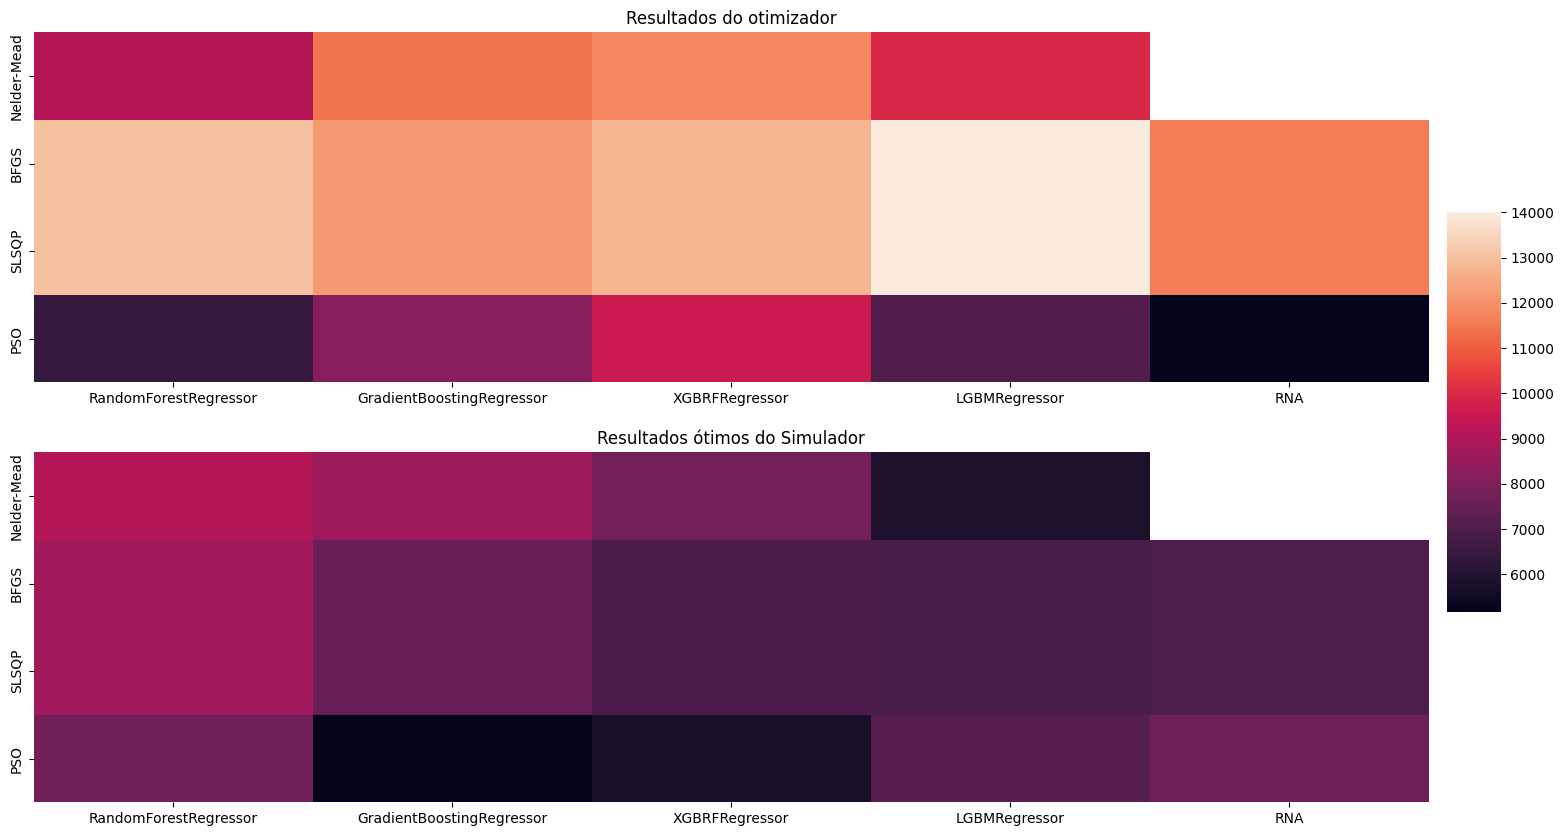

In [ ]:
fig,ax=plt.subplots(2,1,figsize=(18,10))
axes=ax.flatten()
cbar_ax = fig.add_axes([.91, .3, .03, .4])
sns.heatmap(pd.DataFrame(opt_results_dict).replace(to_replace='NOT SUCCESSED',value=np.nan).astype('float64'),mask=pd.DataFrame(opt_results_dict).replace(to_replace='NOT SUCCESSED',value=np.nan).isna(),ax=axes[0],cbar=None)
sns.heatmap(pd.DataFrame(simulation_opt_results_dict).replace(to_replace='NOT SUCCESSED',value=np.nan).abs().astype('float64'),mask=pd.DataFrame(simulation_opt_results_dict).replace(to_replace='NOT SUCCESSED',value=np.nan).isna(),ax=axes[1],vmax=14000,cbar_ax=cbar_ax)
ax[0].set_title('Resultados do otimizador')
ax[1].set_title('Resultados ótimos do Simulador')